##### Discrete Bayes Filter

In [1]:
import numpy as np
from kf_book.book_plots import figsize, set_figsize
import matplotlib.pyplot as plt
import kf_book.book_plots as book_plots

In [2]:
belief = np.array([1/10]*10)
print(belief)

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


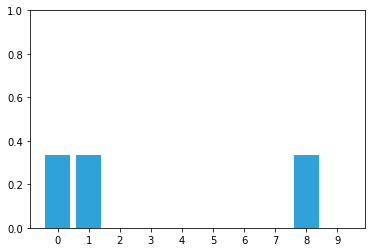

In [3]:
hallway = np.array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0])
belief = hallway/3
book_plots.bar_plot(belief)

belief:  [0.3 0.3 0.1 0.1 0.1 0.1 0.1 0.1 0.3 0.1]
sum =  1.6000000000000003


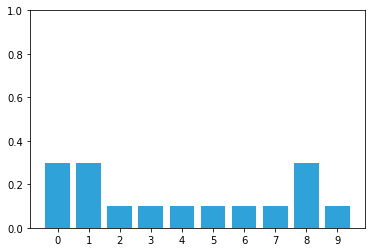

In [4]:
def update_belief(hall, belief, z, correct_scale):
    for i, val in enumerate(hall):
        if val == z:
            belief[i] *= correct_scale

belief = np.array([0.1]*10)
reading = 1 # Door
update_belief(hallway, belief, z = reading, correct_scale = 3)

print('belief: ', belief)
print('sum = ', sum(belief))
book_plots.bar_plot(belief)

belief:  [0.1875 0.1875 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.1875 0.0625]
sum =  1.0


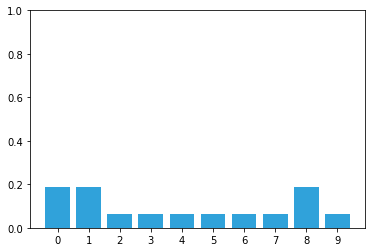

In [5]:
belief = belief/sum(belief)
print('belief: ', belief)
print('sum = ', sum(belief))
book_plots.bar_plot(belief)

In [6]:
belief = np.array([0.1] * 10)
belief[hallway == reading] *= 3
print(belief)

[0.3 0.3 0.1 0.1 0.1 0.1 0.1 0.1 0.3 0.1]


sum =  1.0
probalility of door:  0.1875
probalility of wall:  0.06249999999999999


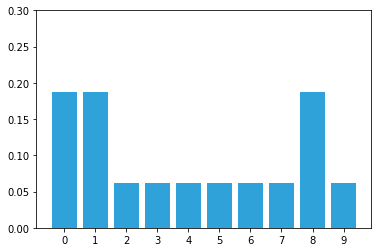

In [7]:
def scaled_update(hall, belief, z, z_prob):
    scale = z_prob / (1 - z_prob)
    belief[hall == z] *= scale
    belief = belief/np.sum(belief)
    return  belief

belief = np.array([0.1] * 10)
belief = scaled_update(hallway, belief, z = 1, z_prob = 0.75)
print('sum = ', sum(belief))
print('probalility of door: ', belief[0])
print('probalility of wall: ', belief[2])
book_plots.bar_plot(belief, ylim = (0, 0.3))

In [8]:
def scaled_update(hall, belief, z, z_prob):
    scale = z_prob/(1 - z_prob)
    likelihood = np.ones(len(hall))
    likelihood[hall == z] *= scale
    return likelihood * belief/np.sum(likelihood * belief)

In [9]:
def update(likelihood, prior):
    return likelihood * belief/np.sum(likelihood * belief)

def lh_hallway(hall, z, z_prob):
    try:
        scale = z_prob/(1 - z_prob)
    except ZeroDivisionError:
        scale = 1e8
    likelihood = np.ones(len(hall))
    likelihood[hall == z] *= scale
    return likelihood

belief = np.array([0.1]*10)
likelihood = lh_hallway(hallway, z = 1, z_prob = 0.75)
update(likelihood, belief)

array([0.1875, 0.1875, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625,
       0.1875, 0.0625])

In [10]:
def perfect_predict(belief, move):
    n = len(belief)
    result = np.zeros(n)
    for i in range(n):
        result[i] = belief[(i - move)]
    return result

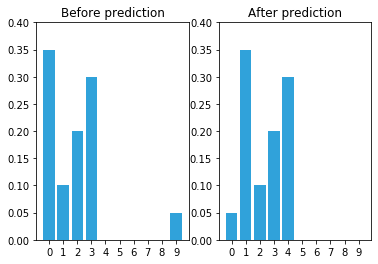

In [11]:
belief = np.array([0.35, 0.1, 0.2, 0.3, 0, 0, 0, 0, 0, 0.05])
plt.subplot(121)
book_plots.bar_plot(belief, title = 'Before prediction', ylim = (0, 0.4))

belief = perfect_predict(belief, 1)
plt.subplot(122)
book_plots.bar_plot(belief, title = 'After prediction', ylim = (0, 0.4))

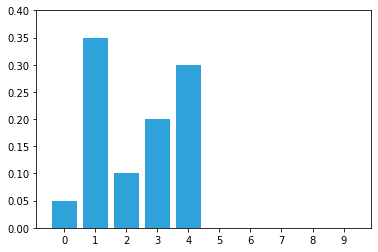

<function __main__.simulate(time_step)>

In [12]:
from ipywidgets import interact, IntSlider

belief = np.array([0.35, 0.1, 0.2, 0.3, 0, 0, 0, 0, 0, 0.05])
beliefs = []

for _ in range(20):
    belief = perfect_predict(belief, 1)
    beliefs.append(belief)

def simulate(time_step):
    book_plots.bar_plot(beliefs[time_step], ylim = (0, 0.4))

interact(simulate, time_step = IntSlider(value = 0, max = len(beliefs) - 1))

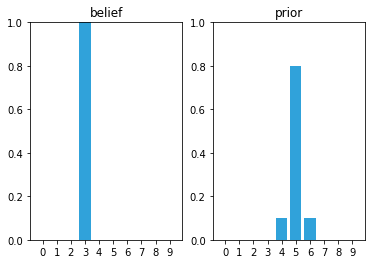

In [13]:
def perfect_move(belief, move, p_under, p_correct, p_over):
    n = len(belief)
    prior = np.zeros(n)
    for i in range(n):
        prior[i] =(
            belief[i - move] * p_correct + 
            belief[i - move - 1] * p_over + 
            belief[i - move + 1] * p_under
        ) 
    return prior

belief = np.zeros(10)
belief[3] = 1

prior = perfect_move(belief, 2, 0.1, 0.8, 0.1)
book_plots.plot_belief_vs_prior(belief, prior)

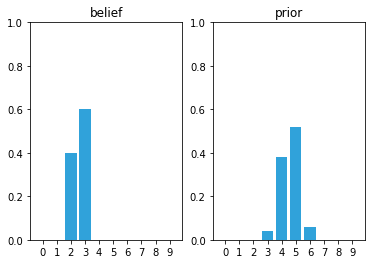

In [14]:
belief = np.zeros(10)
belief[2] = 0.4
belief[3] = 0.6

prior = perfect_move(belief, 2, 0.1, 0.8, 0.1)
book_plots.plot_belief_vs_prior(belief, prior)

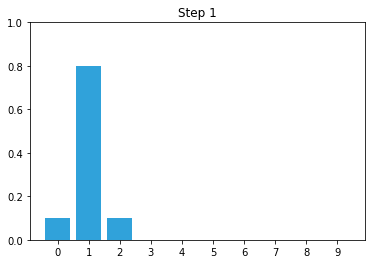

<function __main__.show_prior(step)>

In [15]:
belief = np.zeros(10)
belief[0] = 1
beliefs = []

for i in range(100):
    belief = perfect_move(belief, 1, 0.1, 0.8, 0.1)
    beliefs.append(belief)

def show_prior(step):
    book_plots.bar_plot(beliefs[step - 1])
    plt.title('Step {}'.format(step))

interact(show_prior, step = IntSlider(value = 1, max = len(beliefs)))

In [16]:
print('Final Belief: ', belief)

Final Belief:  [0.10407069 0.10329322 0.10125784 0.09874205 0.09670682 0.09592945
 0.09670682 0.09874205 0.10125784 0.10329322]


## Convolution
1. For continuous function

$$\Huge (f*g)(t) = \int_{0}^{t} f(\tau)g(t-\tau) d\tau$$

2. For discrete function

$$\Huge (f*g)[t] = \sum_{\tau = 0}^{t} f[\tau]g[t-\tau] $$


In [17]:
def predict_move_convolution(pdf, offset, kernel):
    N = len(pdf)
    kN = len(kernel)
    width = int((kN - 1)/2)
    
    prior = np.zeros(N)
    
    for i in range(N):
        for k in range(kN):
            index = (i + (width - k) - offset) % N
            prior[i] += pdf[index] * kernel[k]
    return prior

In [18]:
from scipy.ndimage.filters import convolve
from scipy.ndimage.interpolation import shift

def predict(pdf, offset, kernel, mode='wrap', cval=0.):
    if mode == 'wrap':
        return convolve(np.roll(pdf, offset), kernel, mode='wrap')

    return convolve(shift(pdf, offset, cval=cval), kernel,
                    cval=cval, mode='constant')

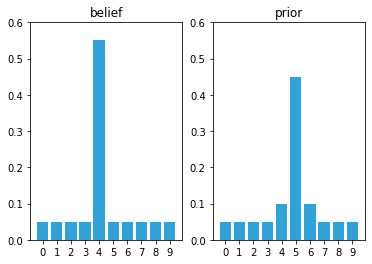

In [19]:
belief = np.ones(10) * 0.05
belief[4] = 0.55
prior = predict(belief, offset = 1, kernel = [0.1, 0.8, 0.1])
book_plots.plot_belief_vs_prior(belief, prior, ylim = (0, 0.6))

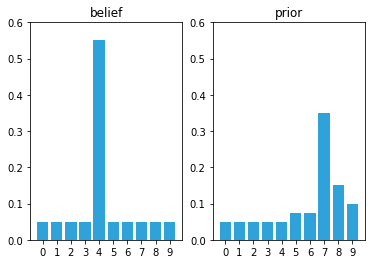

In [20]:
prior = predict(belief, offset = 3, kernel = [0.05, 0.05, 0.6, 0.2, 0.1])
book_plots.plot_belief_vs_prior(belief, prior, ylim  = (0, 0.6))

In [21]:
def update(likelihood, prior):
    return likelihood * prior/np.sum(likelihood * prior)

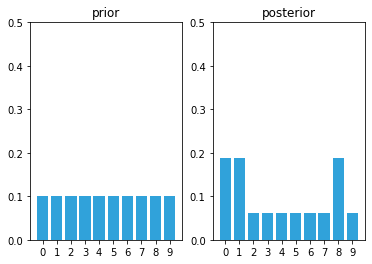

In [22]:
hallway = np.array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0])
prior = np.array([0.1] * 10)
likelihood =  lh_hallway(hallway, z = 1, z_prob = 0.75)
posterior = update(likelihood, prior)
book_plots.plot_prior_vs_posterior(prior, posterior, ylim = (0, 0.5))

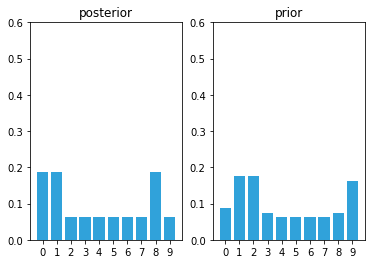

In [23]:
kernel = [0.1, 0.8, 0.1]
prior = predict(posterior, 1, kernel)
book_plots.plot_prior_vs_posterior(prior, posterior, True, ylim = (0, 0.6))

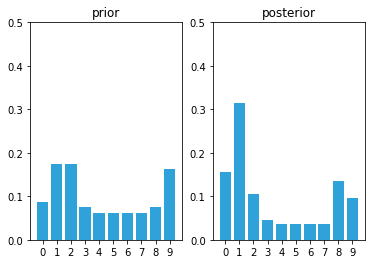

In [24]:
likelihood = lh_hallway(hallway, z = 1, z_prob = 0.75)
posterior = update(likelihood, prior)
book_plots.plot_prior_vs_posterior(prior, posterior, ylim = (0, 0.5))

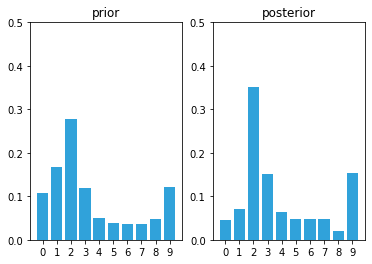

In [25]:
prior = predict(posterior, 1, kernel)
likelihood = lh_hallway(hallway, z = 0, z_prob = 0.75)
posterior = update(likelihood, prior)
book_plots.plot_prior_vs_posterior(prior, posterior, ylim = (0, 0.5))

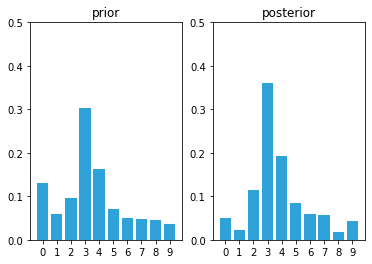

In [26]:
prior = predict(posterior, 1, kernel)
likelihood = lh_hallway(hallway, z = 0, z_prob = 0.75)
posterior = update(likelihood, prior)
book_plots.plot_prior_vs_posterior(prior, posterior, ylim = (0, 0.5))

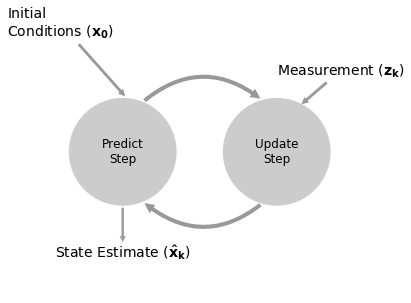

In [27]:
book_plots.predict_update_chart()

## Initialization

1. Initialize our belief in the state

## Predict

1. Based on the system behavior, predict state fot the next time step

2. Adjust belief to account for the uncertainty in prediction

## Update

1. Get a measurement and associated belief about its accuracy

2. Compute how likely it is the measurement matches each state

3. Update state belief with this likelihood



In [28]:
def discrete_bayes_sim(prior, kernel, measurements, z_prob, hallway = hallway):
    posterior = np.array([0.1] * 10)
    priors, posteriors = [], []
    for i, z in enumerate(measurements):
        prior = predict(posterior, 1, kernel)
        priors.append(prior)
        
        likelihood = lh_hallway(hallway, z, z_prob)
        posterior = update(likelihood, prior)
        posteriors.append(posterior)
    return priors, posteriors

def plot_posterior(posteriors, i):
    plt.title('Posterior')
    book_plots.bar_plot(hallway, c = 'k')
    book_plots.bar_plot(posteriors[i], ylim = (0, 1.0))
    plt.axvline(i % len(hallway), lw = 5)

def plot_prior(priors, i):
    plt.title('Prior')
    book_plots.bar_plot(hallway, c = 'k')
    book_plots.bar_plot(priors[i], ylim = (0, 1.0), c = '#ff8015')
    plt.axvline(i % len(hallway), lw = 5)
    
def animate_discrete_bayes(step):
    step -= 1
    i = step //2
    if step % 2 == 0:
        plot_prior(priors, i)
    else:
        plot_posterior(posteriors, i)
        
    

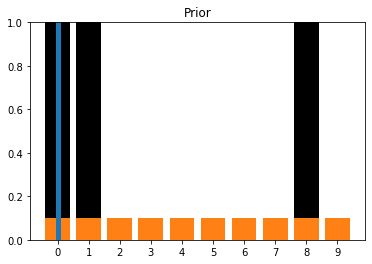

<function __main__.animate_discrete_bayes(step)>

In [29]:
kernel = [0.1, 0.8, 0.1]
z_prob = 1
hallway = np.array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0])

zs = [hallway[i % len(hallway)] for i in range(50)]

priors, posteriors = discrete_bayes_sim(prior, kernel, zs, z_prob)
interact(animate_discrete_bayes, step = IntSlider(value = 1, max = len(zs) * 2))

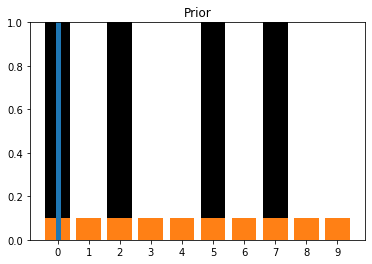

<function __main__.animate_discrete_bayes(step)>

In [30]:
hallway = np.array([1, 0, 1, 0, 0] * 2)
kernel = (0.1, 0.8, 0.1)
prior = np.array([0.1]  * 10)
z_prob = 0.75
priors, posteriors = discrete_bayes_sim(prior, kernel, zs, z_prob, hallway)
interact(animate_discrete_bayes, step = IntSlider(value = 1, max = len(zs) * 2))

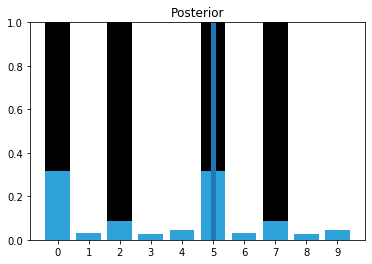

<function __main__.animate_discrete_bayes(step)>

In [31]:
hallway = np.array([1, 0, 1, 0, 0] * 2)
kernel = np.array([0.1, 0.8, 0.1])
prior = np.array([0.1] * 10)
zs = [1, 0, 1, 0, 0, 1]
z_prob = 0.75

priors, posteriors = discrete_bayes_sim(prior, kernel, zs, z_prob, hallway)
interact(animate_discrete_bayes, step =IntSlider(value = 12, max = len(zs) *2))

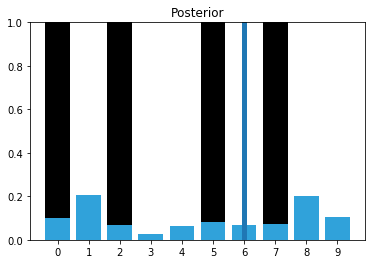

In [32]:
measurements = [1, 0, 1, 0, 0, 1, 1]
priors, posteriors = discrete_bayes_sim(prior, kernel, measurements, z_prob)
plot_posterior(posteriors, 6)

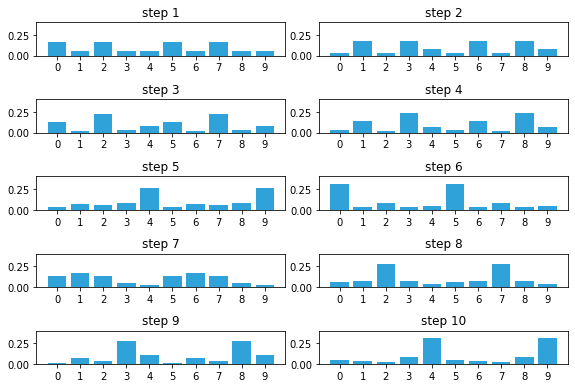

In [33]:
with figsize(y = 5.5):
    measurements = [1, 0, 1, 0, 0, 1, 1, 1, 0, 0]
    for i,m in enumerate(measurements):
        likelihood = lh_hallway(hallway, z = m, z_prob = 0.75)
        posterior = update(likelihood, prior)
        prior = predict(posterior, 1, kernel)
        plt.subplot(5, 2, i+1)
        book_plots.bar_plot(posterior, ylim = (0, 0.4), title = 'step {}'.format(i+1))
    plt.tight_layout()

In [34]:
def normalize(x):
    return x/np.sum(x)

In [45]:
class Train(object):
    
    def __init__(self, track_len, kernel = [1.0], sensor_accuracy = 0.9):
        self.track_len = track_len
        self.pos = 0
        self.kernel = kernel
        self.sensor_accuracy = sensor_accuracy
    
    def move(self, distance = 1):
        self.pos += distance
        r = random.random()
        s = 0
        offset = -(len(self.kernel) - 1)/2
        for k in self.kernel:
            s += k
            if r <= s:
                break
            offset += 1
        self.pos = int((self.pos + offset) % self.track_len)
        return self.pos
    
    def sense(self):
        pos = self.pos
        if random.random() > self.sensor_accuracy:
            if random.random() > 0.5:
                pos += 1
            else:
                pos -= 1
        return pos

In [52]:
def train_filter(iterations, kernel, sensor_accuracy, move_distance, do_print = True):
    track = np.linspace(0,9,10).astype('int')
    prior = np.array([0.9] + [0.01] * 9)
    posterior = prior[:]
    normalize(prior)

    robot = Train(len(track), kernel, sensor_accuracy)
    for i in range(iterations):
        robot.move(distance = move_distance)

        prior = predict(posterior, move_distance, kernel)

        m = robot.sense()
        likelihood = lh_hallway(track, m, sensor_accuracy)

        posterior = update(likelihood, prior)
        index = np.argmax(posterior)

        if do_print:
            print('time {}, pos {}, sense{}, at position {}'.format(i, robot.pos, m, track[robot.pos]))

            print('estimated position is {}, with confidence {:.4f}%'.format(index, posterior[index]*100))

        book_plots.bar_plot(posterior)

        if do_print:
            print()
            print('Final position is ', robot.pos)
            index = np.argmax(posterior)
            print('Estimated position is {} with confidence {:.4f}'.format(index, posterior[index]*100))

time 0, pos 4, sense4, at position 4
estimated position is 4, with confidence 99.9900%

Final position is  4
Estimated position is 4 with confidence 99.9900
time 1, pos 8, sense8, at position 8
estimated position is 8, with confidence 100.0000%

Final position is  8
Estimated position is 8 with confidence 100.0000
time 2, pos 2, sense2, at position 2
estimated position is 2, with confidence 100.0000%

Final position is  2
Estimated position is 2 with confidence 100.0000
time 3, pos 6, sense6, at position 6
estimated position is 6, with confidence 100.0000%

Final position is  6
Estimated position is 6 with confidence 100.0000


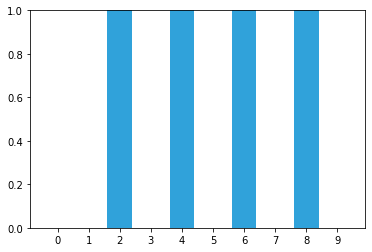

In [53]:
import random

random.seed(1)

np.set_printoptions(precision = 2, suppress = True, linewidth = 60)
train_filter(4, kernel = [1.0], sensor_accuracy = 0.999, move_distance = 4, do_print = True)

time 0, pos 4, sense4, at position 4
estimated position is 4, with confidence 96.0390%

Final position is  4
Estimated position is 4 with confidence 96.0390
time 1, pos 8, sense8, at position 8
estimated position is 8, with confidence 96.8094%

Final position is  8
Estimated position is 8 with confidence 96.8094
time 2, pos 2, sense2, at position 2
estimated position is 2, with confidence 96.9180%

Final position is  2
Estimated position is 2 with confidence 96.9180
time 3, pos 6, sense6, at position 6
estimated position is 6, with confidence 96.9331%

Final position is  6
Estimated position is 6 with confidence 96.9331


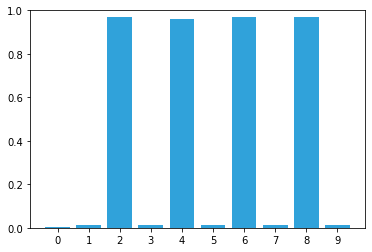

In [55]:
import random

random.seed(1)

np.set_printoptions(precision = 2, suppress = True, linewidth = 60)

train_filter(4, kernel = [0.1, 0.8, 0.1], sensor_accuracy = 0.9, move_distance = 4, do_print = True)